<a href="https://colab.research.google.com/github/tiskutis/Brolis/blob/main/Chemometrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [258]:
import pandas as pd
from pandas import Series
from google.colab import drive
from os.path import join
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [191]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [192]:
ref_spectra = pd.read_csv('/content/drive/MyDrive/Brolis/Task/Data_prepared_syntetic/Data_prepared_syntetic/Reference_spectra.csv')

In [193]:
ref_spectra

,wavelength,glucose_absorptivity,water_absorptivity
0,2000,0.020000,0.021852
1,2001,0.020000,0.021761
2,2002,0.020000,0.021671
3,2003,0.020000,0.021580
4,2004,0.020000,0.021489
...,...,...,...
396,2396,0.019621,0.021489
397,2397,0.019639,0.021580
398,2398,0.019655,0.021671
399,2399,0.019671,0.021761


In [194]:
path = '/content/drive/MyDrive/Brolis/Task/Data_prepared_syntetic/Data_prepared_syntetic'
filenames = [f for f in listdir(path) if f.endswith('.h5')]

In [195]:
files = []

for filename in filenames:
  file_info = {}
  with h5py.File(join(path, filename), "r") as f:
    a_group_key = list(f.keys())[0]
    group = f[a_group_key]

    file_info['absorbance'] = group['block0_values'][()]
    file_info['wavelength'] = group['block1_values'][()]
    file_info['concentration'] = abs(float(re.findall(r"[-+]?\d*\.\d+|\d+", filename)[0]))
    files.append(file_info)

In [196]:
for file in files:
  print(min(file['wavelength']), max(file['wavelength']))

[2000] [2400]
[2000] [2400]
[2000] [2400]
[2000] [2400]
[2000] [2400]
[2000] [2400]
[2000] [2400]
[2000] [2400]
[2000] [2400]
[2000] [2400]


In [197]:
#All measurements are in range of 2000-2400 nm so I take wavelenghts only from
#the first measurement. 

data = {'wavelength': files[0]['wavelength'].flatten()}

for file in files:
  concentration = file['concentration']
  key = f'absorbance c={concentration}'
  data[key] = file['absorbance'].flatten()

In [198]:
df = pd.DataFrame(data)

In [199]:
df = pd.merge(df, ref_spectra, on='wavelength')

In [200]:
df.shape

(401, 13)

In [202]:
df.head()

,wavelength,absorbance c=0.03,absorbance c=0.04,absorbance c=0.07,absorbance c=0.05,absorbance c=0.06,absorbance c=0.12,absorbance c=0.1,absorbance c=0.08,absorbance c=0.09,absorbance c=0.11,glucose_absorptivity,water_absorptivity
0,2000,0.001091,0.001085,0.001084,0.001094,0.001094,0.001080,0.001087,0.001081,0.001083,0.001079,0.02,0.021852
1,2001,0.001090,0.001078,0.001078,0.001087,0.001088,0.001081,0.001084,0.001084,0.001087,0.001080,0.02,0.021761
2,2002,0.001077,0.001083,0.001075,0.001071,0.001075,0.001076,0.001072,0.001090,0.001068,0.001071,0.02,0.021671
3,2003,0.001082,0.001074,0.001072,0.001080,0.001078,0.001073,0.001074,0.001075,0.001080,0.001075,0.02,0.021580
4,2004,0.001072,0.001075,0.001070,0.001067,0.001078,0.001068,0.001077,0.001067,0.001065,0.001065,0.02,0.021489


In [223]:
dataframes = []

for column in df.columns:
  if 'absorbance' in column:
    # print(column)
    target_concentration = re.findall(r"[-+]?\d*\.\d+|\d+", column)[0]
    # print(target_concentration)
    temp_df = pd.DataFrame({'absorbance':df[column],
                            'glucose_absorptivity': df['glucose_absorptivity'],
                            'water_absorptivity': df['water_absorptivity'],
                            'concentration': target_concentration})
    
    # print(temp_df)
    # print(df[column])
    dataframes.append(temp_df)

df_new = pd.concat(dataframes)

In [231]:
df_new = df_new.sample(frac=1).reset_index(drop=True)

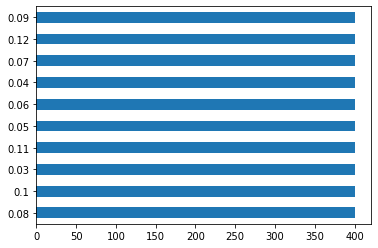

In [233]:
df_new.concentration.value_counts().plot(kind = 'barh')

In [246]:
X = df_new.drop(['concentration'], axis=1)
y = df_new['concentration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [250]:
reg = LinearRegression().fit(X_train, y_train)

In [256]:
y_pred = reg.predict(X_test)

In [259]:
mean_squared_error(y_test, y_pred)

0.0005946196836121249